In [299]:
from sys import argv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import subprocess
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import argparse
import sys

## PCA Transformation

In [177]:
# Method to calculate dimensions based on the co-variance
def calculate_dimensions(feature, feature_name):
    pca_dims = PCA()
    pca_dims.fit(cld_features_vector)
    cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.95) + 1
    print('{} Dimension : {}'.format(feature_name, d))
    return d

In [178]:
# Perfome PCA on data features
def fit_pca(dim, data_feature, query_feature):
    pca = PCA(n_components=dim)
    data_feature = pca.fit_transform(data_feature)
    print('Data Feature Shape : {}'.format(data_feature.shape))
    query_feature = pca.transform(query_feature)
    print('Query Feature Shape : {}'.format(query_feature.shape))
    return data_feature, query_feature

## Get Label from Image Name

In [57]:
def get_label(name):
    start = name.find('_') + len('_')
    end = name.find('.')
    label = name[start:end]
#     print('Label : {}'.format(label))
    return label

## Image display method

In [111]:
# Display result images
def display_result(data):
    img_array = []
    for i in data.index:
        arr = []
        img = Image.open(data[0][i])
        arr.append(img)
        arr.append(data['label'][i])
        img_array.append(arr)
    
    # Top 10 Search Results
    print('TOP 10 SEARCH RESULT')
    plt.figure(figsize=(15,15))
    for i in range(len(img_array)):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img_array[i][0], cmap=plt.cm.binary)
        plt.xlabel(img_array[i][1])
    plt.show()

## Get Data from Feature csv

In [424]:
# Read Cifar Complete Features
cifar_features = pd.read_csv('CifarTrainFeature.csv', header=None)
# Read CLD Features
cld_features = pd.read_csv('CLDFeature.csv', header=None)
# Read SCD Features
scd_features = pd.read_csv('SCDFeature.csv', header=None)
# Read EHD Features
ehd_features = pd.read_csv('EHDFeature.csv', header=None)
# Read CEDD Features
cedd_features = pd.read_csv('CEDDFeature.csv', header=None)

In [210]:
# Dropping 1st column from the dataframe
cld_features_vector = cld_features.drop(columns=[0])
scd_features_vector = scd_features.drop(columns=[0])
ehd_features_vector = ehd_features.drop(columns=[0])
cedd_features_vector = cedd_features.drop(columns=[0])


In [429]:
print('CIFAR Complete Feature Shape : {}'.format(cifar_features.drop(columns=[0]).shape))
print('CLD Feature Shape : {}'.format(cld_features_vector.shape))
print('SCD Feature Shape : {}'.format(scd_features_vector.shape))
print('EHD Feature Shape : {}'.format(ehd_features_vector.shape))
print('CEDD Feature Shape : {}'.format(cedd_features_vector.shape))

CIFAR Complete Feature Shape : (50000, 321)
CLD Feature Shape : (50000, 33)
SCD Feature Shape : (50000, 64)
EHD Feature Shape : (50000, 80)
CEDD Feature Shape : (50000, 144)


## Query Image

In [211]:
query = '/Users/prafulla/eclipse-workspace/MPEGFeatureExtractor/train/22394_automobile.png'

QUERY IMAGE..


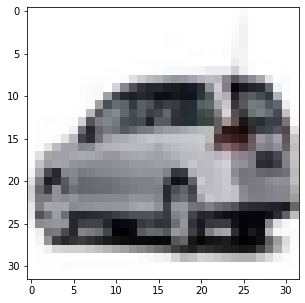

In [212]:
# Query Image
print('QUERY IMAGE..')
query_img = Image.open(query)
plt.figure(figsize=(5,5))
plt.imshow(query_img, cmap=plt.cm.binary)
plt.show()

In [213]:
query_cld = cld_features.loc[cld_features[0] == os.path.abspath(query)]
query_scd = scd_features.loc[scd_features[0] == os.path.abspath(query)]
query_ehd = ehd_features.loc[ehd_features[0] == os.path.abspath(query)]
query_cedd = cedd_features.loc[cedd_features[0] == os.path.abspath(query)]


In [214]:
# Dropping 1st column from the dataframe
query_cld_vector = query_cld.drop(columns=[0])
query_scd_vector = query_scd.drop(columns=[0])
query_ehd_vector = query_ehd.drop(columns=[0])
query_cedd_vector = query_cedd.drop(columns=[0])

### Get Label from Image Name by calling get_label method

In [152]:
frogy = '/Users/prafulla/eclipse-workspace/MPEGFeatureExtractor/train/248_frog.png'
name = os.path.basename(frogy)
print(name)
get_label(name)

248_frog.png


'frog'

In [153]:
# Getting label from directory
label = []
for i in cifar_features.index:
    label.append(get_label(os.path.basename(cifar_features[0][i])))

In [154]:
# query image label
query_label = get_label(os.path.basename(query))
query_label

'automobile'

## CLD Feature Image Retrieval
#### MPEG-7 Standard Distance Measure - Euclidean Distance

In [412]:
dim = calculate_dimensions(cld_features_vector, 'CLD')
data_feature_cld, query_feature_cld = fit_pca(dim, cld_features_vector, query_cld_vector)

CLD Dimension : 22
Data Feature Shape : (50000, 22)
Query Feature Shape : (1, 22)


In [414]:
# cosine similarity between query image and complete dataset
cos_sim_cld = pd.DataFrame(cosine_similarity(query_feature_cld, data_feature_cld).flatten(), columns=['cos_sim'])
# euclidean distance between query image and complete dataset
euc_dis_cld = pd.DataFrame(euclidean_distances(query_feature_cld, data_feature_cld).flatten(), columns=['euc_dis'])
# manhattan distance between query image and complete dataset
man_dis_cld = pd.DataFrame(manhattan_distances(query_feature_cld, data_feature_cld, sum_over_features=True).flatten(), columns=['man_dis'])
# Add cosine similarity as lasy column in data feature dataframe as ground truth
dataset_cld = pd.concat([cld_features, cos_sim_cld, euc_dis_cld, man_dis_cld, pd.DataFrame(label, columns=['label'])], axis=1)


In [415]:
# sorting result in descending order
cos_sim_result = dataset_cld.sort_values(by='cos_sim', ascending=False)[[0, 'cos_sim', 'label']].head(10)
# sorting result in descending order
euc_dis_result = dataset_cld.sort_values(by='euc_dis', ascending=True)[[0, 'euc_dis', 'label']].head(10)
# Manhattan Distance sorting
man_dis_result = dataset_cld.sort_values(by='man_dis', ascending=True)[[0, 'man_dis', 'label']].head(10)
# cos_sim_result

In [416]:
cos_sim_match = sum(1 for label in cos_sim_result['label'] if query_label in label)
print('Cosine Similarity Matching Result : {}'.format(cos_sim_match))
euc_dis_match = sum(1 for label in euc_dis_result['label'] if query_label in label)
print('Euclidean Distance Matching Result : {}'.format(euc_dis_match))
man_dis_match = sum(1 for label in man_dis_result['label'] if query_label in label)
print('Manhattan Distance Matching Result : {}'.format(man_dis_match))

Cosine Similarity Matching Result : 7
Euclidean Distance Matching Result : 8
Manhattan Distance Matching Result : 8


In [417]:
class_object_count = sum(1 for label in dataset_cld['label'] if query_label in label)
class_object_count

5000

### PRECISION

In [418]:
cos_sim_precision = (cos_sim_match / cos_sim_result[0].size)
print('Cosine Similarity Precision : {}%'.format(cos_sim_precision*100))
euc_dis_precision = (euc_dis_match / euc_dis_result[0].size)
print('Euclidean Distance Precision : {}%'.format(euc_dis_precision*100))
man_dis_precision = (man_dis_match / man_dis_result[0].size)
print('Manhattan Distance Precision : {}%'.format(man_dis_precision*100))

Cosine Similarity Precision : 70.0%
Euclidean Distance Precision : 80.0%
Manhattan Distance Precision : 80.0%


### RECALL

In [419]:
cos_sim_recall = (cos_sim_match / class_object_count)
print('Cosine Similarity Recall : {}%'.format(cos_sim_recall*100))
euc_dis_recall = (euc_dis_match / class_object_count)
print('Euclidean Distance Precision : {}%'.format(euc_dis_recall*100))
man_dis_recall = (man_dis_match / class_object_count)
print('Manhattan Distance Precision : {}%'.format(man_dis_recall*100))

Cosine Similarity Recall : 0.13999999999999999%
Euclidean Distance Precision : 0.16%
Manhattan Distance Precision : 0.16%


## F1 Score

In [420]:
cos_sim_f1 = 2 * (cos_sim_precision * cos_sim_recall) / (cos_sim_precision + cos_sim_recall)
print('Cosine Similarity F1 Score : {}'.format(cos_sim_f1))
euc_dis_f1 = 2 * (euc_dis_precision * euc_dis_recall) / (euc_dis_precision + euc_dis_recall)
print('Euclidean Distance F1 Score : {}'.format(euc_dis_f1))
man_dis_f1 = 2 * (man_dis_precision * man_dis_recall) / (man_dis_precision + man_dis_recall)
print('Manhattan Distance F1 Score : {}'.format(man_dis_f1))

Cosine Similarity F1 Score : 0.0027944111776447107
Euclidean Distance F1 Score : 0.0031936127744510976
Manhattan Distance F1 Score : 0.0031936127744510976


COSINE SIMILARITY RESULT
TOP 10 SEARCH RESULT


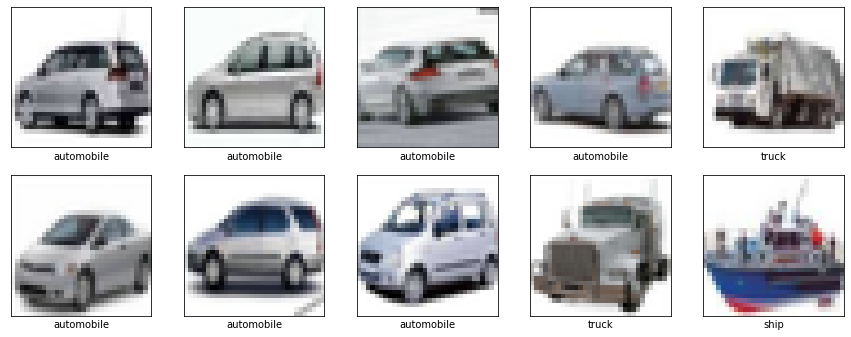

EUCLIDEAN DISTANCE RESULT
TOP 10 SEARCH RESULT


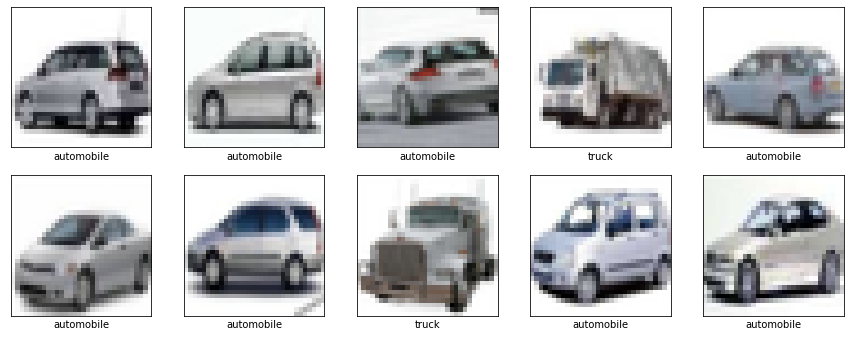

MANHATTAN DISTANCE RESULT
TOP 10 SEARCH RESULT


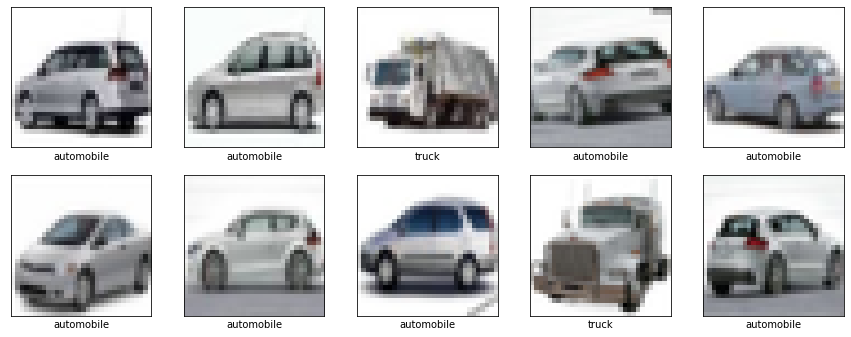

In [421]:
print('COSINE SIMILARITY RESULT')
display_result(cos_sim_result)
print('EUCLIDEAN DISTANCE RESULT')
display_result(euc_dis_result)
print('MANHATTAN DISTANCE RESULT')
display_result(man_dis_result)

### CLD Feature Conclusion :
    Best Result : Euclidean Distance

## SCD Feature Image Retrieval
#### MPEG-7 Standard Distance Measure - Manhattan Distance (L1 Distance)

In [390]:
dim = calculate_dimensions(scd_features_vector, 'SCD')
data_feature_scd, query_feature_scd = fit_pca(dim, scd_features_vector, query_scd_vector)

SCD Dimension : 22
Data Feature Shape : (50000, 22)
Query Feature Shape : (1, 22)


In [391]:
# cosine similarity between query image and complete dataset
cos_sim_scd = pd.DataFrame(cosine_similarity(query_feature_scd, data_feature_scd).flatten(), columns=['cos_sim'])
# euclidean distance between query image and complete dataset
euc_dis_scd = pd.DataFrame(euclidean_distances(query_feature_scd, data_feature_scd).flatten(), columns=['euc_dis'])
# manhattan distance between query image and complete dataset
man_dis_scd = pd.DataFrame(manhattan_distances(query_feature_scd, data_feature_scd, sum_over_features=True).flatten(), columns=['man_dis'])
# Add cosine similarity as lasy column in data feature dataframe as ground truth
dataset_scd = pd.concat([scd_features, cos_sim_scd, euc_dis_scd, man_dis_scd, pd.DataFrame(label, columns=['label'])], axis=1)


In [392]:
# Cosine Similarity sorting
cos_sim_result = dataset_scd.sort_values(by='cos_sim', ascending=False)[[0, 'cos_sim', 'label']].head(10)
# Euclidean Distance sorting
euc_dis_result = dataset_scd.sort_values(by='euc_dis', ascending=True)[[0, 'euc_dis', 'label']].head(10)
# Manhattan Distance sorting
man_dis_result = dataset_scd.sort_values(by='man_dis', ascending=True)[[0, 'man_dis', 'label']].head(10)


In [393]:
cos_sim_match = sum(1 for label in cos_sim_result['label'] if query_label in label)
print('Cosine Similarity Matching Result : {}'.format(cos_sim_match))
euc_dis_match = sum(1 for label in euc_dis_result['label'] if query_label in label)
print('Euclidean Distance Matching Result : {}'.format(euc_dis_match))
man_dis_match = sum(1 for label in man_dis_result['label'] if query_label in label)
print('Manhattan Distance Matching Result : {}'.format(man_dis_match))


Cosine Similarity Matching Result : 4
Euclidean Distance Matching Result : 6
Manhattan Distance Matching Result : 5


### PRECISION

In [394]:
cos_sim_precision = (cos_sim_match / cos_sim_result[0].size)
print('Cosine Similarity Precision : {}%'.format(cos_sim_precision*100))
euc_dis_precision = (euc_dis_match / euc_dis_result[0].size)
print('Euclidean Distance Precision : {}%'.format(euc_dis_precision*100))
man_dis_precision = (man_dis_match / man_dis_result[0].size)
print('Manhattan Distance Precision : {}%'.format(man_dis_precision*100))

Cosine Similarity Precision : 40.0%
Euclidean Distance Precision : 60.0%
Manhattan Distance Precision : 50.0%


### RECALL

In [395]:
cos_sim_recall = (cos_sim_match / class_object_count)
print('Cosine Similarity Recall : {}%'.format(cos_sim_recall*100))
euc_dis_recall = (euc_dis_match / class_object_count)
print('Euclidean Distance Precision : {}%'.format(euc_dis_recall*100))
man_dis_recall = (man_dis_match / class_object_count)
print('Manhattan Distance Precision : {}%'.format(man_dis_recall*100))

Cosine Similarity Recall : 0.08%
Euclidean Distance Precision : 0.12%
Manhattan Distance Precision : 0.1%


## F1 Score

In [396]:
cos_sim_f1 = 2 * (cos_sim_precision * cos_sim_recall) / (cos_sim_precision + cos_sim_recall)
print('Cosine Similarity F1 Score : {}'.format(cos_sim_f1))
euc_dis_f1 = 2 * (euc_dis_precision * euc_dis_recall) / (euc_dis_precision + euc_dis_recall)
print('Euclidean Distance F1 Score : {}'.format(euc_dis_f1))
man_dis_f1 = 2 * (man_dis_precision * man_dis_recall) / (man_dis_precision + man_dis_recall)
print('Manhattan Distance F1 Score : {}'.format(man_dis_f1))

Cosine Similarity F1 Score : 0.0015968063872255488
Euclidean Distance F1 Score : 0.0023952095808383233
Manhattan Distance F1 Score : 0.001996007984031936


COSINE SIMILARITY RESULT
TOP 10 SEARCH RESULT


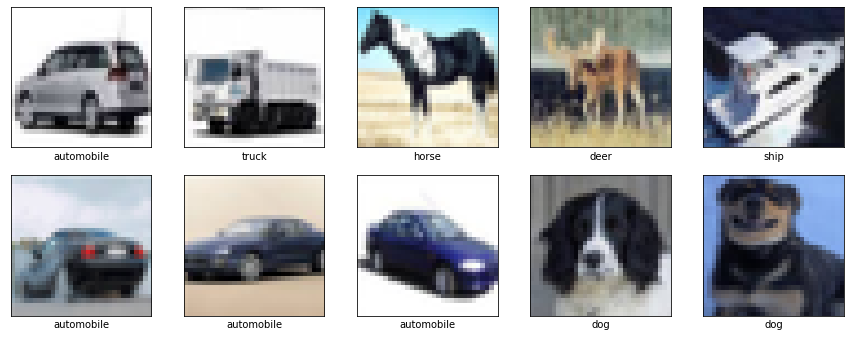

EUCLIDEAN DISTANCE RESULT
TOP 10 SEARCH RESULT


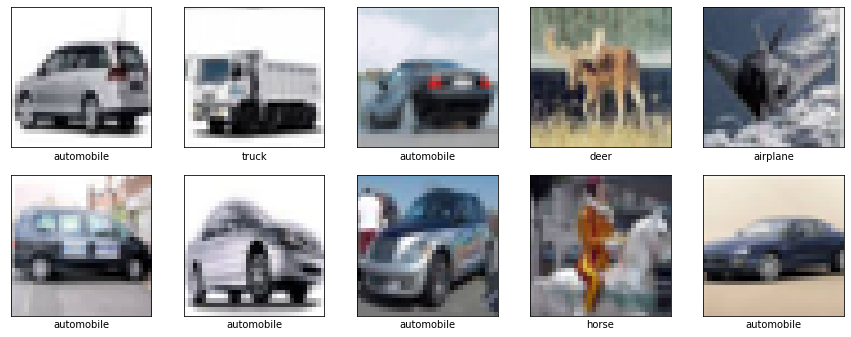

MANHATTAN DISTANCE RESULT
TOP 10 SEARCH RESULT


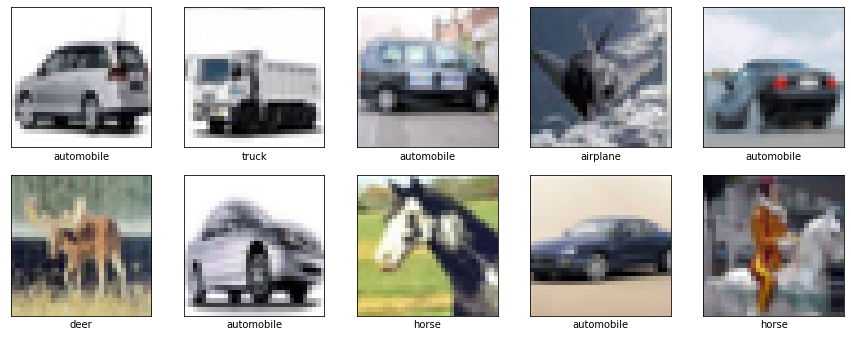

In [397]:
print('COSINE SIMILARITY RESULT')
display_result(cos_sim_result)
print('EUCLIDEAN DISTANCE RESULT')
display_result(euc_dis_result)
print('MANHATTAN DISTANCE RESULT')
display_result(man_dis_result)

### SCD Feature Conclusion :
    Best Result : Euclidean Distance

## EHD Feature Image Retrieval
#### MPEG-7 Standard Distance Measure - Euclidean Distance (L1 Distance)

In [398]:
dim = calculate_dimensions(ehd_features_vector, 'EHD')
data_feature_ehd, query_feature_ehd = fit_pca(dim, ehd_features_vector, query_ehd_vector)

EHD Dimension : 22
Data Feature Shape : (50000, 22)
Query Feature Shape : (1, 22)


In [399]:
# cosine similarity between query image and complete dataset
cos_sim_ehd = pd.DataFrame(cosine_similarity(query_feature_ehd, data_feature_ehd).flatten(), columns=['cos_sim'])
# euclidean distance between query image and complete dataset
euc_dis_ehd = pd.DataFrame(euclidean_distances(query_feature_ehd, data_feature_ehd).flatten(), columns=['euc_dis'])
# manhattan distance between query image and complete dataset
man_dis_ehd = pd.DataFrame(manhattan_distances(query_feature_ehd, data_feature_ehd, sum_over_features=True).flatten(), columns=['man_dis'])
# Add cosine similarity as lasy column in data feature dataframe as ground truth
dataset_ehd = pd.concat([ehd_features, cos_sim_ehd, euc_dis_ehd, man_dis_ehd, pd.DataFrame(label, columns=['label'])], axis=1)


In [400]:
# Cosine Similarity sorting
cos_sim_result = dataset_ehd.sort_values(by='cos_sim', ascending=False)[[0, 'cos_sim', 'label']].head(10)
# Euclidean Distance sorting
euc_dis_result = dataset_ehd.sort_values(by='euc_dis', ascending=True)[[0, 'euc_dis', 'label']].head(10)
# Manhattan Distance sorting
man_dis_result = dataset_ehd.sort_values(by='man_dis', ascending=True)[[0, 'man_dis', 'label']].head(10)

In [401]:
cos_sim_match = sum(1 for label in cos_sim_result['label'] if query_label in label)
print('Cosine Similarity Matching Result : {}'.format(cos_sim_match))
euc_dis_match = sum(1 for label in euc_dis_result['label'] if query_label in label)
print('Euclidean Distance Matching Result : {}'.format(euc_dis_match))
man_dis_match = sum(1 for label in man_dis_result['label'] if query_label in label)
print('Manhattan Distance Matching Result : {}'.format(man_dis_match))

Cosine Similarity Matching Result : 6
Euclidean Distance Matching Result : 6
Manhattan Distance Matching Result : 7


### PRECISION

In [404]:
cos_sim_precision = (cos_sim_match / cos_sim_result[0].size)
print('Cosine Similarity Precision : {}%'.format(cos_sim_precision*100))
euc_dis_precision = (euc_dis_match / euc_dis_result[0].size)
print('Euclidean Distance Precision : {}%'.format(euc_dis_precision*100))
man_dis_precision = (man_dis_match / man_dis_result[0].size)
print('Manhattan Distance Precision : {}%'.format(man_dis_precision*100))

Cosine Similarity Precision : 60.0%
Euclidean Distance Precision : 60.0%
Manhattan Distance Precision : 70.0%


### RECALL

In [405]:
cos_sim_recall = (cos_sim_match / class_object_count)
print('Cosine Similarity Recall : {}%'.format(cos_sim_recall*100))
euc_dis_recall = (euc_dis_match / class_object_count)
print('Euclidean Distance Precision : {}%'.format(euc_dis_recall*100))
man_dis_recall = (man_dis_match / class_object_count)
print('Manhattan Distance Precision : {}%'.format(man_dis_recall*100))

Cosine Similarity Recall : 0.12%
Euclidean Distance Precision : 0.12%
Manhattan Distance Precision : 0.13999999999999999%


## F1 Score

In [406]:
cos_sim_f1 = 2 * (cos_sim_precision * cos_sim_recall) / (cos_sim_precision + cos_sim_recall)
print('Cosine Similarity F1 Score : {}'.format(cos_sim_f1))
euc_dis_f1 = 2 * (euc_dis_precision * euc_dis_recall) / (euc_dis_precision + euc_dis_recall)
print('Euclidean Distance F1 Score : {}'.format(euc_dis_f1))
man_dis_f1 = 2 * (man_dis_precision * man_dis_recall) / (man_dis_precision + man_dis_recall)
print('Manhattan Distance F1 Score : {}'.format(man_dis_f1))

Cosine Similarity F1 Score : 0.0023952095808383233
Euclidean Distance F1 Score : 0.0023952095808383233
Manhattan Distance F1 Score : 0.0027944111776447107


COSINE SIMILARITY RESULT
TOP 10 SEARCH RESULT


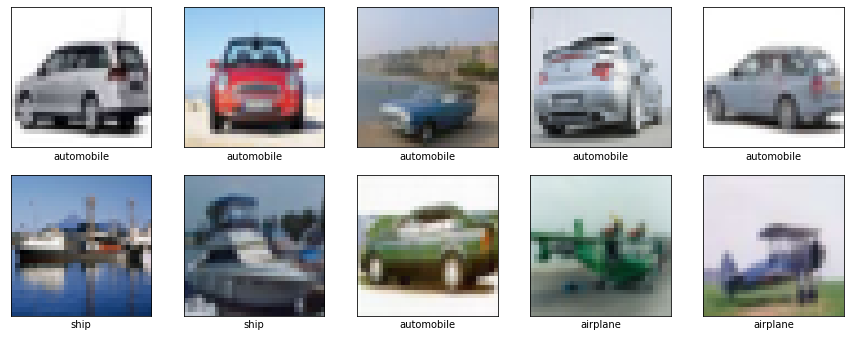

EUCLIDEAN DISTANCE RESULT
TOP 10 SEARCH RESULT


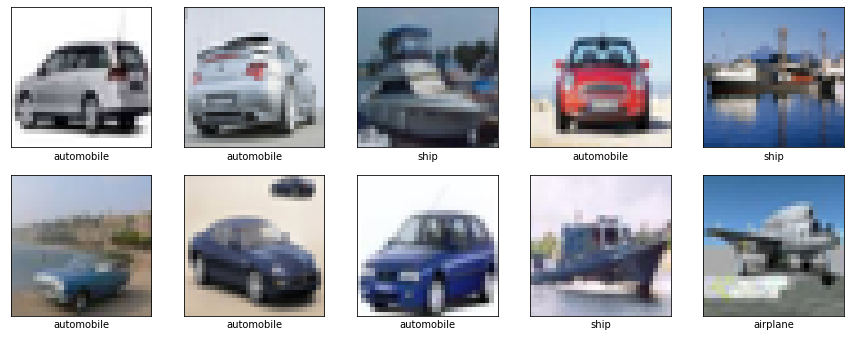

MANHATTAN DISTANCE RESULT
TOP 10 SEARCH RESULT


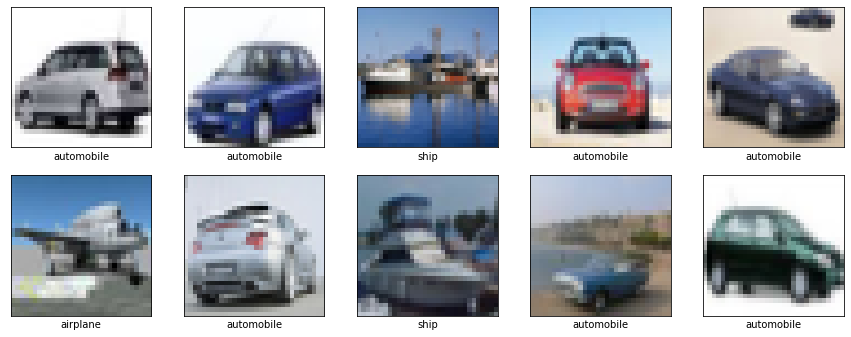

In [407]:
print('COSINE SIMILARITY RESULT')
display_result(cos_sim_result)
print('EUCLIDEAN DISTANCE RESULT')
display_result(euc_dis_result)
print('MANHATTAN DISTANCE RESULT')
display_result(man_dis_result)

### EHD Feature Conclusion :
    Best Result : Manhattan Distance

# Linear Regression on all 3 Descriptors for Better Result

In [320]:
# CLD Descriptor Similarity/Distance Score
simd1 = dataset_cld[['euc_dis']]
simd1 = simd1.div(simd1.max()).rename(columns={'euc_dis': 'd1'})
# SCD Descriptor Similarity/Distance Score
simd2 = dataset_scd[['euc_dis']]
simd2 = simd2.div(simd2.max()).rename(columns={'euc_dis': 'd2'})
# EHD Descriptor Similarity/Distance Score
simd3 = dataset_ehd[['man_dis']]
simd3 = simd3.div(simd3.max()).rename(columns={'man_dis': 'd3'})


In [342]:
sim_val =simd1.values + simd2.values + simd3.values
sim_F1F2F3 = pd.DataFrame(sim_val, columns=['simval'])
dataset_result = pd.concat([cifar_features[0], sim_F1F2F3,simd1,simd2,simd3], axis=1)
sort_result_F4 = dataset_result.sort_values(by='simval', ascending=True).head(20)
# sort_result_F4

In [300]:
X = sort_result_F4.iloc[:,2:]         
X = X.fillna(0)
df = pd.DataFrame(sort_result_F4[0].str.split('.',1, expand=True))
df = pd.DataFrame(df[0].str.split('_',1, expand=True))
df[1] = df[1].map({"airplane": 1, "automobile": 2, "bird":3, "cat": 4, "deer": 5, "dog": 6, "frog": 7, "horse": 8, "ship": 9, "truck": 10})
Y = df[1]    
reg = LinearRegression().fit(X, Y)
    

In [365]:
print('Weight1 : {}, Weight2 : {}, Weight3 : {}'.format(reg.coef_[0], reg.coef_[1], reg.coef_[2]))
similarity_result = (reg.coef_[0]*sort_result_F4['d1'].values) + (reg.coef_[1]*sort_result_F4['d2'].values) + (reg.coef_[2]*sort_result_F4['d3'].values)


Weight1 : 17.187579195231013, Weight2 : -3.22828079834693, Weight3 : -6.982414174059236


In [366]:
image = pd.DataFrame(sort_result_F4[0].values, columns=[0])
similarity = pd.concat([image, pd.DataFrame(similarity_result, columns=['similarity'])], axis=1)

In [367]:
# Getting label from directory
final_label = []
for i in similarity.index:
    final_label.append(get_label(os.path.basename(similarity[0][i])))

In [368]:
result = pd.concat([similarity, pd.DataFrame(final_label, columns=['label'])], axis=1)
final_result = result.sort_values(by='similarity', ascending=False).head(10)

In [370]:
final_match = sum(1 for label in final_result['label'] if query_label in label)
print('Matching Result : {}'.format(final_match))

Matching Result : 8


## PRECISION

In [408]:
final_precision = (final_match / final_result[0].size)
print('Precision : {}%'.format(final_precision*100))

Precision : 80.0%


## RECALL

In [409]:
final_recall = (final_match / class_object_count)
print('Recall : {}%'.format(final_recall*100))

Recall : 0.16%


## F1 Score

In [410]:
final_f1 = 2 * (final_precision * final_recall) / (final_precision + final_recall)
print('F1 Score : {}'.format(final_f1))

F1 Score : 0.0031936127744510976


TOP 10 SEARCH RESULT


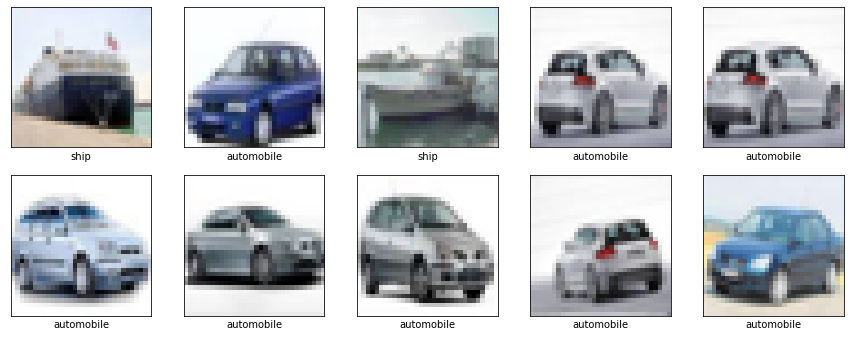

In [411]:
display_result(final_result)

## CONCLUSION : Combining all the descriptors and applying linear regression on the similarity scores increases the retrieval accuracy